In [1]:
import pandas as pd
model_performance = pd.read_csv('/kaggle/input/results/model_performance.csv')
outfield_data_df = pd.read_csv('/kaggle/input/outfield-player-data/combined_other_position_data.csv')

# Prepare player data

In [68]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df, cols):
    # Create a OneHotEncoder object
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    # Fit and transform the 'Position' column
    df_encoded = pd.DataFrame(encoder.fit_transform(df[cols]))
    df_encoded.columns = encoder.get_feature_names_out()

    df.drop(cols, axis=1, inplace=True)
    return pd.concat([df, df_encoded], axis = 1)

outfield_cols = ['Position', 'Categorized Position', 'League']
outfield_data_df = one_hot_encoding(outfield_data_df, outfield_cols)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Select features (X) and target variable (y)
outfield_X = outfield_data_df.drop(['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate', 'Birthday', 'Injuries', 'Type of Injury', 'Categorized Injuries'], axis=1)
outfield_y = outfield_data_df[['Total Days', 'Total Games Missed', 'Injury Count', 'Average Injury Cost', 'Injury Rate']]

# Split the data into training and testing sets
outfield_X_train, outfield_X_test, outfield_y_train, outfield_y_test = train_test_split(outfield_X, outfield_y, test_size=0.2, random_state=42)

# Get the column names to be scaled
cols_to_scale = outfield_X.columns.difference(['Name', 'Club'])

# Perform scaling only on the selected columns
scaler = MinMaxScaler()
outfield_X[cols_to_scale] = scaler.fit_transform(outfield_X[cols_to_scale])

In [70]:
default_prediction_df = outfield_data_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:']]
# Group by 'Club' and calculate total minutes played
club_total_minutes = default_prediction_df.groupby('Club')['Minutes Played Total 23/24:'].sum()

# Calculate individual player weights
default_prediction_df['Weight'] = default_prediction_df['Minutes Played Total 23/24:'] / default_prediction_df['Club'].map(club_total_minutes)

In [71]:
default_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight
0,Tosin Adarabioyo,Fulham,26,1995,0.041889
1,Issa Diop,Fulham,27,1949,0.040923
2,Calvin Bassey,Fulham,24,2562,0.053794
3,Tim Ream,Fulham,36,1692,0.035527
4,Antonee Robinson,Fulham,26,3749,0.078718


# Find Best Performing Model on 'Injury Rate'

In [6]:
injury_rate_models = model_performance[model_performance['Target'] == 'Injury Rate']
print(injury_rate_models.idxmin())

Model                                 44
Target                                 4
Mean Square Error                     44
Mean Absolute Error                   44
Normalized Root Mean Square Error     44
R-Squared Error                      122
dtype: int64


## Based on MSE, MAE and NRMSE

In [7]:
model_performance.iloc[[44]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
44,Decision Tree,Injury Rate,9.763372e-14,1.458457e-08,0.000895,0.999999


In [100]:
import pickle

# Load the saved model
with open("/kaggle/input/injury-rate-predictor/Decision Tree_Injury Rate.sav", "rb") as f:
    injury_rate_mse_model = pickle.load(f)

## Predicting based on MSE, MAE and NRMSE

In [9]:
injury_rate_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

injury_rate_predictions = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_injury_rate = injury_rate_mse_model.predict(X_test)
    injury_rate_predictions.append(predicted_injury_rate[0])

injury_rate_mse_prediction_df['Predicted Injury Rate'] = injury_rate_predictions
injury_rate_mse_prediction_df.to_csv('injury_rate_mse_prediction.csv', index=False)
injury_rate_mse_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Injury Rate
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,0.000504
1,Issa Diop,Fulham,27,1949,0.040923,0.000504
2,Calvin Bassey,Fulham,24,2562,0.053794,0.000504
3,Tim Ream,Fulham,36,1692,0.035527,0.000504
4,Antonee Robinson,Fulham,26,3749,0.078718,0.000504


## Based on R Squared Error

In [6]:
model_performance.iloc[[122]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
122,Neural Network,Injury Rate,0.067344,0.177419,1.316764,-553035.69929


# Find Best Performing Model on 'Total Days'

In [6]:
total_days_models = model_performance[model_performance['Target'] == 'Total Days']
print(total_days_models.idxmin())

Model                                 40
Target                                 0
Mean Square Error                    100
Mean Absolute Error                  121
Normalized Root Mean Square Error     75
R-Squared Error                       50
dtype: int64


## Based on MSE

In [7]:
model_performance.iloc[[100]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
100,Voting Regressor,Total Days,2993.668443,35.232941,1.823566,0.228574


In [8]:
import pickle

# Load the saved model
with open("/kaggle/input/total-days-predictors/Voting Regressor_Total Days.sav", "rb") as f:
    total_days_mse_model = pickle.load(f)

## Predicting based on MSE

In [9]:
total_days_out_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_total_days_out.append(total_days_mse_model.predict(X_test)[0])

total_days_out_mse_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_mse_prediction_df.to_csv('total_days_out_mse_prediction.csv', index=False)
total_days_out_mse_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Days Out
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,77.408900
1,Issa Diop,Fulham,27,1949,0.040923,78.596995
2,Calvin Bassey,Fulham,24,2562,0.053794,22.061949
3,Tim Ream,Fulham,36,1692,0.035527,56.835895
4,Antonee Robinson,Fulham,26,3749,0.078718,12.757569


## Based on MAE

In [72]:
model_performance.iloc[[121]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
121,Neural Network,Total Days,4331.870115,35.098744,10.036033,-0.116261


In [73]:
from tensorflow.keras.models import load_model

# Load the model
total_days_mae_model = load_model('/kaggle/input/total_days_predictors/keras/default/1/nn_total_days_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
total_days_out_mae_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)  # Ensure correct shape
    X_test = X_test.astype(np.float32)  # Convert to appropriate data type if needed
    predicted_total_days_out.append(total_days_mae_model.predict(X_test)[0])

total_days_out_mae_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_mae_prediction_df.to_csv('total_days_out_mse_prediction.csv', index=False)
total_days_out_mae_prediction_df.head()

## Based on NRMSE

In [10]:
model_performance.iloc[[75]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
75,Random Forest (PCA n = 13),Total Days,5567.24183,44.997821,1.244698,-0.434599


In [11]:
# Load the saved model
with open("/kaggle/input/total-days-predictors/Random Forest (PCA n 13)_Total Days.sav", "rb") as f:
    total_days_nrmse_model = pickle.load(f)

In [12]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=13)
outfield_X_pca = pca.fit_transform(outfield_X.drop(['Name', 'Club'], axis=1))

# Create a new DataFrame with the reduced features and original columns
outfield_X_pca_df = pd.DataFrame(outfield_X_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'PCA13'])
outfield_X_pca_df['Name'] = outfield_X['Name']
outfield_X_pca_df['Club'] = outfield_X['Club']

total_days_out_nrmse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_total_days_out = []
for index, row in outfield_X_pca_df.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_total_days_out.append(total_days_nrmse_model.predict(X_test)[0])

total_days_out_nrmse_prediction_df['Predicted Days Out'] = predicted_total_days_out
total_days_out_nrmse_prediction_df.to_csv('total_days_out_nrmse_prediction.csv', index=False)
total_days_out_nrmse_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Days Out
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,46.0
1,Issa Diop,Fulham,27,1949,0.040923,46.0
2,Calvin Bassey,Fulham,24,2562,0.053794,149.0
3,Tim Ream,Fulham,36,1692,0.035527,46.0
4,Antonee Robinson,Fulham,26,3749,0.078718,51.0


# Find Best Performing Model on 'Average Injury Cost'

In [96]:
avg_injury_cost_models = model_performance[model_performance['Target'] == 'Average Injury Cost']
print(avg_injury_cost_models.idxmin())

Model                                 43
Target                                 3
Mean Square Error                    103
Mean Absolute Error                  103
Normalized Root Mean Square Error    123
R-Squared Error                      123
dtype: int64


## Based on MSE and MAE

In [97]:
model_performance.iloc[[103]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
103,Voting Regressor,Average Injury Cost,0.01714,0.09957,1.72559,0.204248


In [101]:
# Load the saved model
with open("/kaggle/input/average-injury-cost-predictors/Voting Regressor_Average Injury Cost.sav", "rb") as f:
    avg_injury_cost_mse_model = pickle.load(f)

In [103]:
avg_injury_cost_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_avg_injury_cost = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_avg_injury_cost.append(avg_injury_cost_mse_model.predict(X_test)[0])

avg_injury_cost_mse_prediction_df['Predicted Average Injury Cost'] = predicted_avg_injury_cost
avg_injury_cost_mse_prediction_df.to_csv('avg_injury_cost_mse_prediction.csv', index=False)
avg_injury_cost_mse_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Average Injury Cost
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,0.295183
1,Issa Diop,Fulham,27,1949,0.040923,0.317022
2,Calvin Bassey,Fulham,24,2562,0.053794,0.168393
3,Tim Ream,Fulham,36,1692,0.035527,0.210753
4,Antonee Robinson,Fulham,26,3749,0.078718,0.145121


## Based on NRMSE

In [98]:
model_performance.iloc[[123]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
123,Neural Network,Average Injury Cost,0.042462,0.138214,1.091839,-0.971411


In [106]:
# Load the model
avg_injury_cost_nrmse_model = load_model('/kaggle/input/average_injury_cost_nn/tensorflow1/ts/1/nn_avg_injury_cost_model.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 9 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
avg_injury_cost_nrmse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_avg_injury_cost = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)  # Ensure correct shape
    X_test = X_test.astype(np.float32)  # Convert to appropriate data type if needed
    predicted_avg_injury_cost.append(avg_injury_cost_nrmse_model.predict(X_test)[0])

avg_injury_cost_nrmse_prediction_df['Predicted Average Injury Cost'] = predicted_avg_injury_cost
avg_injury_cost_nrmse_prediction_df.to_csv('avg_injury_cost_nrmse_prediction.csv', index=False)
avg_injury_cost_nrmse_prediction_df.head()

# Find Best Performing Model on 'Injury Count'

In [108]:
injury_count_models = model_performance[model_performance['Target'] == 'Injury Count']
print(injury_count_models.idxmin())

Model                                 42
Target                                 2
Mean Square Error                    102
Mean Absolute Error                  102
Normalized Root Mean Square Error     77
R-Squared Error                       47
dtype: int64


## Based on MSE and MAE

In [109]:
model_performance.iloc[[102]]

,Model,Target,Mean Square Error,Mean Absolute Error,Normalized Root Mean Square Error,R-Squared Error
102,Voting Regressor,Injury Count,1.025086,0.778629,1.769107,0.233516


In [110]:
# Load the saved model
with open("/kaggle/input/injury-count-predictors/Voting Regressor_Injury Count.sav", "rb") as f:
    injury_count_mse_model = pickle.load(f)

In [112]:
injury_count_mse_prediction_df = default_prediction_df[['Name', 'Club', 'Age', 'Minutes Played Total 23/24:', 'Weight']]

predicted_injury_count = []
for index, row in outfield_X.iterrows():
    X_test = row.drop(['Name', 'Club']).values.reshape(1, -1)
    predicted_injury_count.append(injury_count_mse_model.predict(X_test)[0])

injury_count_mse_prediction_df['Predicted Injury Count'] = predicted_injury_count
injury_count_mse_prediction_df.to_csv('injury_count_mse_prediction.csv', index=False)
injury_count_mse_prediction_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Injury Count
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,1.894689
1,Issa Diop,Fulham,27,1949,0.040923,2.068261
2,Calvin Bassey,Fulham,24,2562,0.053794,1.066523
3,Tim Ream,Fulham,36,1692,0.035527,1.387498
4,Antonee Robinson,Fulham,26,3749,0.078718,0.895854


# Perform Optimisation

## Import relevant files


In [8]:
total_days_out_mse_prediction_df = pd.read_csv('/kaggle/input/total-days-out-predictions/total_days_out_mse_prediction.csv')
total_days_out_nrmse_prediction_df = pd.read_csv('/kaggle/input/total-days-out-predictions/total_days_out_nrmse_prediction.csv')

## When Objective function is based on 'Total Days Out'
Given a squad of $n$ players which plays $g$ number of games per season, the objective function is

$\begin{align*} 
    \min \; &\lambda \sum_{i = 1}^{n} w_i z_i x_i + (1 - \lambda)\delta(x_i - \text{ min. playing time})^2\\
    \text{s.t. } &\sum_{i = 1}^{n} x_i = 90 \times 10 \times g\\
    &90 \times l_k \times g \leq x_i \leq 90 \times u_k \times g\\
    & x_i \geq 0
\end{align*}$

where $w_i$ is the **weight (importance)**, $z_i$ is the **predicted total days out from injuries** and $x_i$ is the **minutes played across the whole season** for player $i$. $\lambda$ is the tradeoff term between minimizing injury risk and ensuring performance, while $\delta$ controls the severity of the penalty. 

$l_k$ and $u_k$ are the lower and upper bound of the age group playing time that player $i$ belongs to which by default follows this table:

|    Age Group | Suggested Minutes Lower Bound | Suggested Minutes Upper Bound |
|-------------:|------------------------------:|------------------------------:|
|     16 to 22 |                            15 |                            60 |
|     23 to 35 |                            70 |                            90 |
| 35 and above |                            15 |                            70 |

In other words, given a team of players, we are trying to minimise potential impact of player $i$'s injuries on the team. At the same time, we want to ensure that important players still play a fair amount of games even if their predicted days out due to injury is high. A higher $w_i z_i x_i$ value indicates a greater negative impact due to:

- Higher weight: The player is more important to the team.
- Higher predicted days out: The player is more likely to be injured for a longer duration.
- Higher playing time: The player is exposed to more potential injury risks.

By minimizing this objective, the optimization problem seeks to allocate playing time in a way that reduces the overall negative impact of injuries on the team but still taking into consideration the performance of the team. This can help ensure that the team remains competitive and avoids excessive absences due to injuries.

Note that the variables $g, \; \lambda, \; \delta$ and the age group constraints are adjustable based on the needs of different teams.

In [9]:
import numpy as np
from scipy.optimize import minimize

def objective_function(x, df, games_per_season, age_ranges, lambda_penalty=0.5):
    """
    Calculates the weighted sum of predicted total days out.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., weights, predicted days out, age).
    games_per_season: Number of games played per season.
    minutes_per_age: Dictionary of minutes limits for different age groups.
    lambda_penalty: Tradeoff control between minimizing injury risk and ensuring playing time.

    Returns:
    The weighted sum of predicted total days out.
    """

    predicted_days_out = df['Predicted Days Out'].values
    weights = df['Weight'].values
    min_playing_time = df['Min Playing Time'].values
    
    # Calculate penalty term
    penalty = 1000 * np.power(x - min_playing_time, 2)
    return lambda_penalty * np.dot(weights, predicted_days_out * x) + (1 - lambda_penalty) * (np.sum(penalty))



def age_ub_constraint(x, df, games_per_season, age_ranges):
    """
    Enforces individual playing time limits based on age.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., age).
    age_ranges: List of tuples representing age ranges and their corresponding minutes limits.

    Returns:
    A tuple of constraint values.
    """

    age = df['Age'].values
    ub_constraints = []
    
    for i in range(len(x)):
        for age_range, minutes_limit in age_ranges:
            if age_range[0] <= age[i] <= age_range[1]:
                ub_constraints.append(games_per_season * minutes_limit[1] - x[i])
                break  # Exit the loop if a match is found

    return ub_constraints

def age_lb_constraint(x, df, games_per_season, age_ranges):
    """
    Enforces individual playing time limits based on age.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., age).
    age_ranges: List of tuples representing age ranges and their corresponding minutes limits.

    Returns:
    A tuple of constraint values.
    """

    age = df['Age'].values
    lb_constraints = []
    
    for i in range(len(x)):
        for age_range, minutes_limit in age_ranges:
            if age_range[0] <= age[i] <= age_range[1]:
                lb_constraints.append(x[i] - games_per_season * minutes_limit[0])
                break  # Exit the loop if a match is found

    return lb_constraints

def total_playing_time_constraint(x, games_per_season):
    """
    Enforces the total playing time constraint.

    Args:
    x: Array of playing minutes for each player.
    games_per_season: Number of games played per season.

    Returns:
    The constraint value.
    """
#     print((games_per_season * 90 * 10), np.sum(x))
    return (games_per_season * 90 * 10) - np.sum(x)

def non_negative_constraint(x):
    """
    Enforces non-negativity of playing time.

    Args:
    x: Array of playing minutes for each player.

    Returns:
    The constraint value.
    """

    return x

In [10]:
pd.options.mode.chained_assignment = None

def get_min_playing_times(base_min_playing_time, club_players_df):
    weight_quantiles = club_players_df['Weight'].quantile([0.5, 0.65, 0.8])

    for index, row in club_players_df.iterrows():
        if row['Weight'] >= weight_quantiles[0.8]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 1.5
        elif row['Weight'] >= weight_quantiles[0.65]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time * 1.25
        elif row['Weight'] >= weight_quantiles[0.5]:
              club_players_df.loc[index, 'Min Playing Time'] = base_min_playing_time
        else:
              club_players_df.loc[index, 'Min Playing Time'] = 0

    return club_players_df

default_age_ranges = [((16, 22), (15, 60)), 
                      ((23, 35), (70, 90)), 
                      ((35, 50), (15, 70))]


def optimise(club_name, df, age_ranges=default_age_ranges, games_per_season=50, penalty_lambda=0.5):
    club_players_df = df[df['Club'] == club_name]
    num_players = len(club_players_df)
    total_available_minutes = games_per_season * 90 * 10
    base_min_playing_time = total_available_minutes / num_players
    club_players_df = get_min_playing_times(base_min_playing_time, club_players_df)

    x0 = np.full(num_players, base_min_playing_time)  # Initial guess for playing minutes

    constraints = ({'type': 'eq', 'fun': lambda x: total_playing_time_constraint(x, games_per_season)},
                 {'type': 'ineq', 'fun': lambda x: age_ub_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': lambda x: age_lb_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': non_negative_constraint})

    # Solve the optimization problem
    result = minimize(objective_function, x0, args=(club_players_df, games_per_season, age_ranges, penalty_lambda), method='SLSQP', constraints=constraints)

    optimal_playing_minutes = result.x
    rounded_optimal_playing_minutes = [round(value) for value in optimal_playing_minutes]
    club_players_df['Lambda'] = penalty_lambda  # Store the used lambda value for each player
    club_players_df['Suggested Minutes'] = rounded_optimal_playing_minutes
    return club_players_df

## Lambda as the variable

In [30]:
man_city_df = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.9)
man_city_df

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Days Out,Min Playing Time,Lambda,Suggested Minutes
198,Rúben Dias,Man City,27,3817,0.061609,11.715614,2934.782609,0.9,2448
199,Manuel Akanji,Man City,28,3861,0.062319,12.118954,3521.739130,0.9,3800
200,Nathan Aké,Man City,29,3053,0.049278,13.162987,2347.826087,0.9,2198
201,John Stones,Man City,30,1858,0.029990,56.180477,0.000000,0.9,2643
202,Taylor Harwood-Bellis,Man City,22,3942,0.063627,8.670015,3521.739130,0.9,3070
203,Josko Gvardiol,Man City,22,3479,0.056154,27.903629,2347.826087,0.9,1540
204,Sergio Gómez,Man City,23,445,0.007183,48.224480,0.000000,0.9,2643
205,Josh Wilson-Esbrand,Man City,21,1248,0.020144,41.408318,0.000000,0.9,889
206,Rico Lewis,Man City,19,1606,0.025922,23.911762,0.000000,0.9,889
207,Kyle Walker,Man City,34,4083,0.065903,19.281223,3521.739130,0.9,3800


### Specific for when $\lambda = 0.9$
- This means we are more focused on preventing injury risks

Text(0.5, 1.0, 'Suggested Minutes vs. Predicted Days Out')

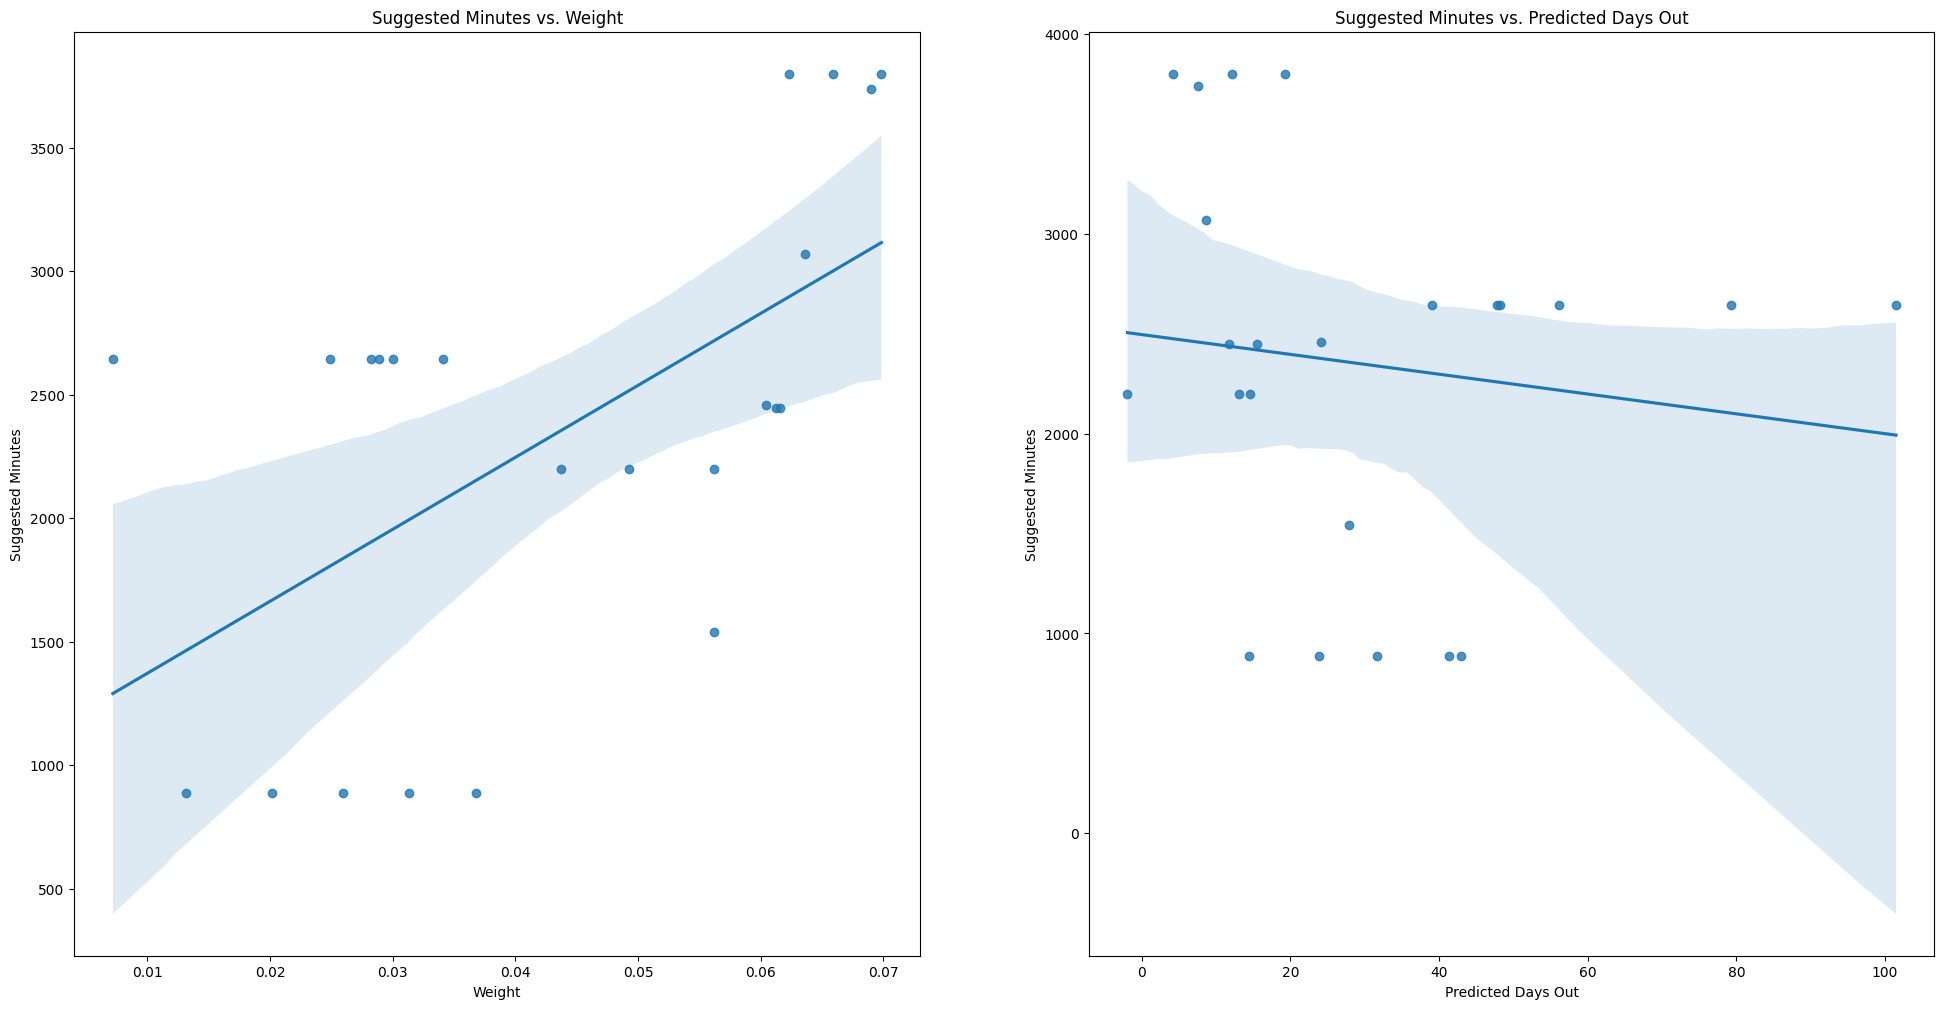

In [31]:
# Create separate line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title('Suggested Minutes vs. Weight')

sns.regplot(data=man_city_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title('Suggested Minutes vs. Predicted Days Out')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Sergio Gómez's Suggested Minutes vs. Lambda")

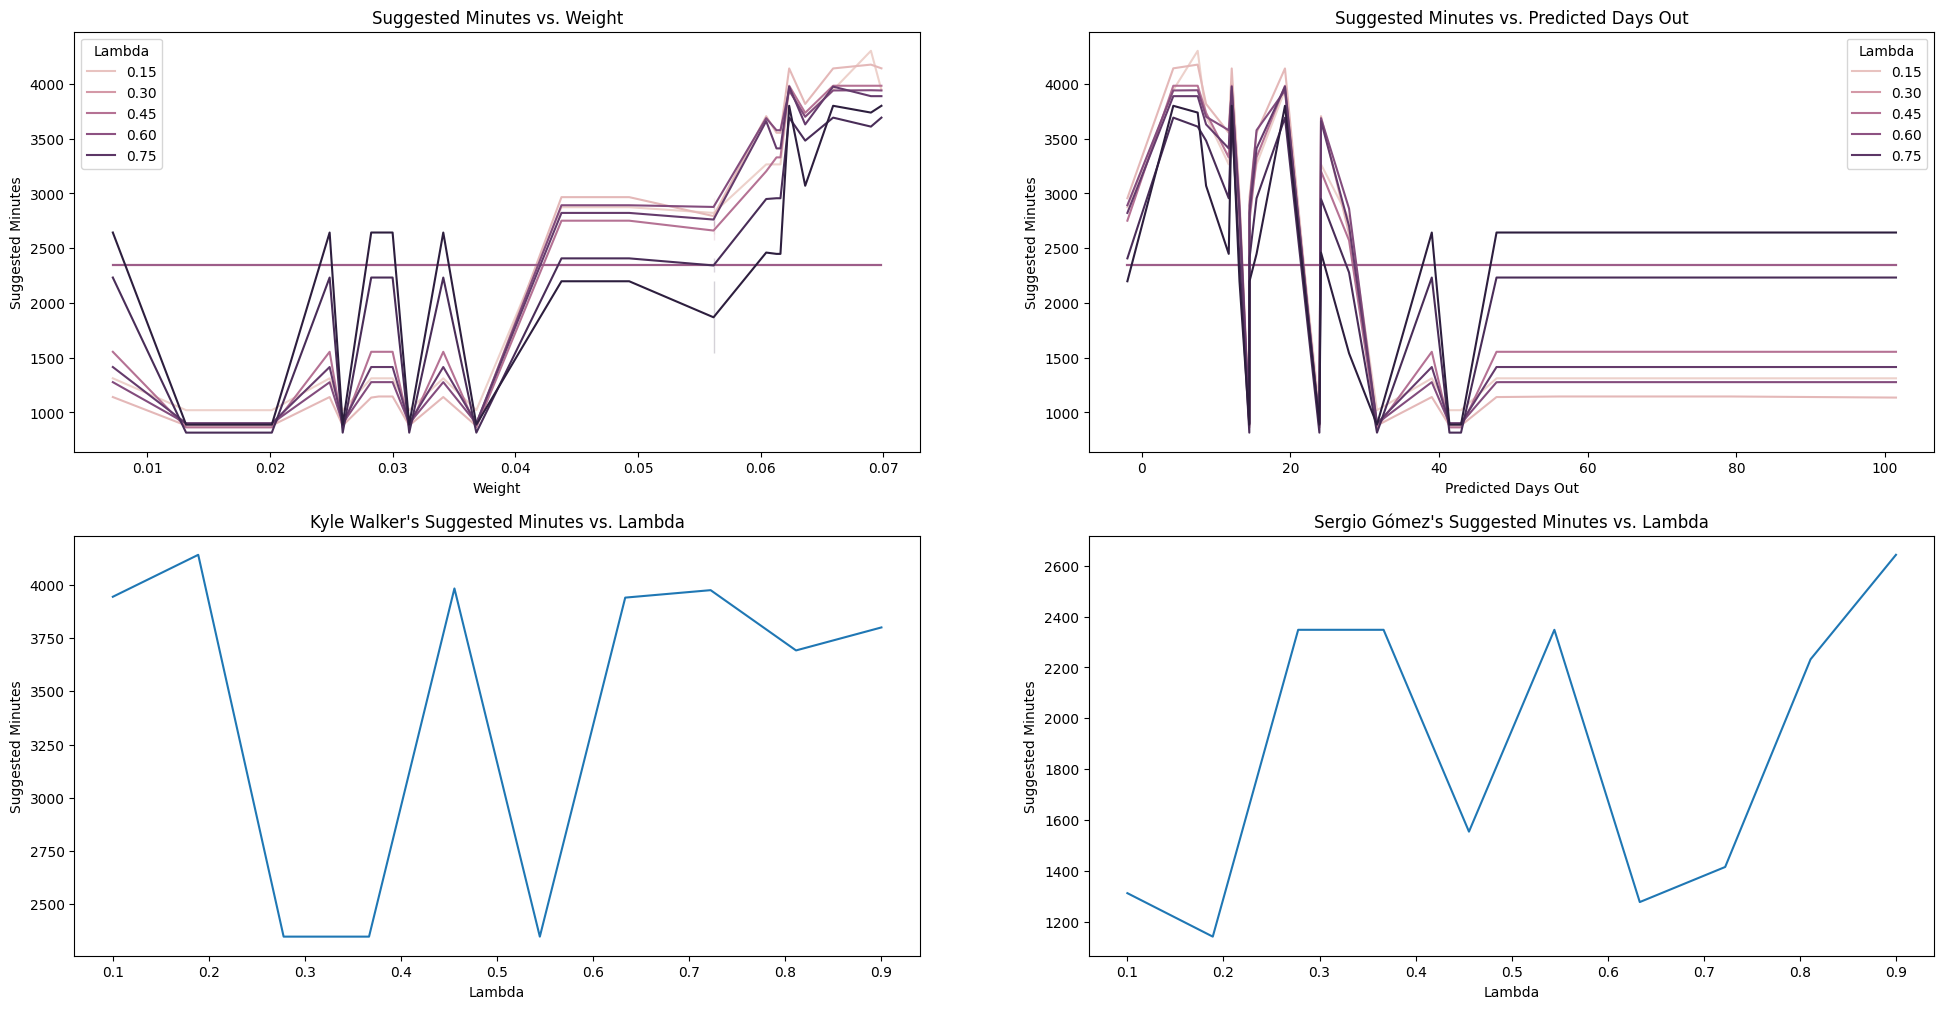

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title('Suggested Minutes vs. Weight')

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title('Suggested Minutes vs. Predicted Days Out')

walker_df = results_df[results_df['Name'] == 'Kyle Walker']
sns.lineplot(data=walker_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Kyle Walker's Suggested Minutes vs. Lambda")

sergio_df = results_df[results_df['Name'] == 'Sergio Gómez']
sns.lineplot(data=sergio_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Sergio Gómez's Suggested Minutes vs. Lambda")

In [32]:
real_madrid_df = optimise('Real Madrid', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=0.9)
real_madrid_df

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Days Out,Min Playing Time,Lambda,Suggested Minutes
849,Éder Militão,Real Madrid,26,505,0.009740,161.049497,0.000000,0.9,2663
850,David Alaba,Real Madrid,31,1407,0.027136,137.460755,0.000000,0.9,2663
851,Antonio Rüdiger,Real Madrid,31,3986,0.076876,13.708890,3857.142857,0.9,3943
852,Nacho Fernández,Real Madrid,34,3035,0.058534,15.343626,3214.285714,0.9,2494
853,Ferland Mendy,Real Madrid,28,2744,0.052922,51.527754,2571.428571,0.9,2528
854,Fran García,Real Madrid,24,1686,0.032517,35.197406,0.000000,0.9,2663
855,Daniel Carvajal,Real Madrid,32,3261,0.062893,25.899997,3857.142857,0.9,3814
856,Lucas Vázquez,Real Madrid,32,1780,0.034330,16.854470,0.000000,0.9,2663
857,Aurélien Tchouaméni,Real Madrid,24,2809,0.054176,25.589066,2571.428571,0.9,2528
858,Federico Valverde,Real Madrid,25,4190,0.080810,4.016790,3857.142857,0.9,3943


Text(0.5, 1.0, "Real Madrid's Suggested Minutes vs. Predicted Days Out")

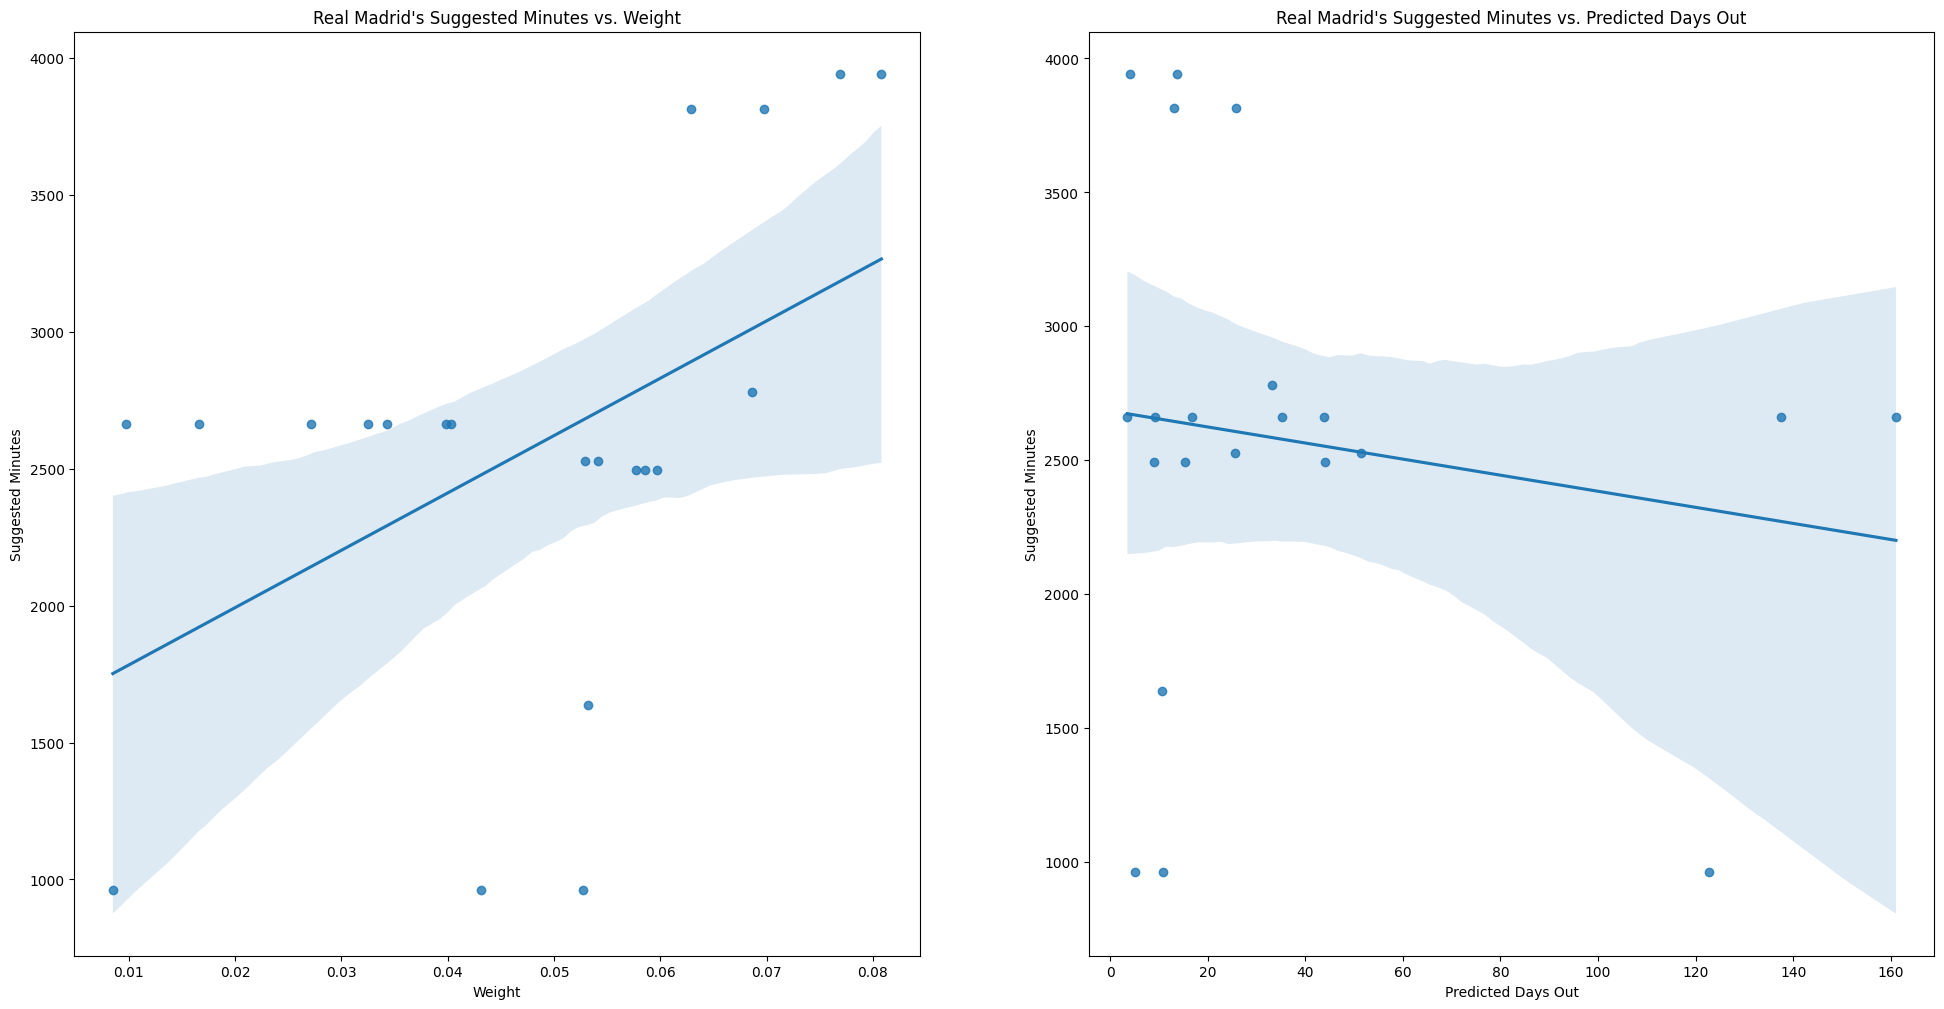

In [33]:
# Create separate line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
# Plot suggested minutes vs. weights
sns.regplot(data=real_madrid_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title("Real Madrid's Suggested Minutes vs. Weight")

sns.regplot(data=real_madrid_df, x='Predicted Days Out', y='Suggested Minutes', ax=axes[1])
axes[1].set_title("Real Madrid's Suggested Minutes vs. Predicted Days Out")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Guler's Suggested Minutes vs. Lambda")

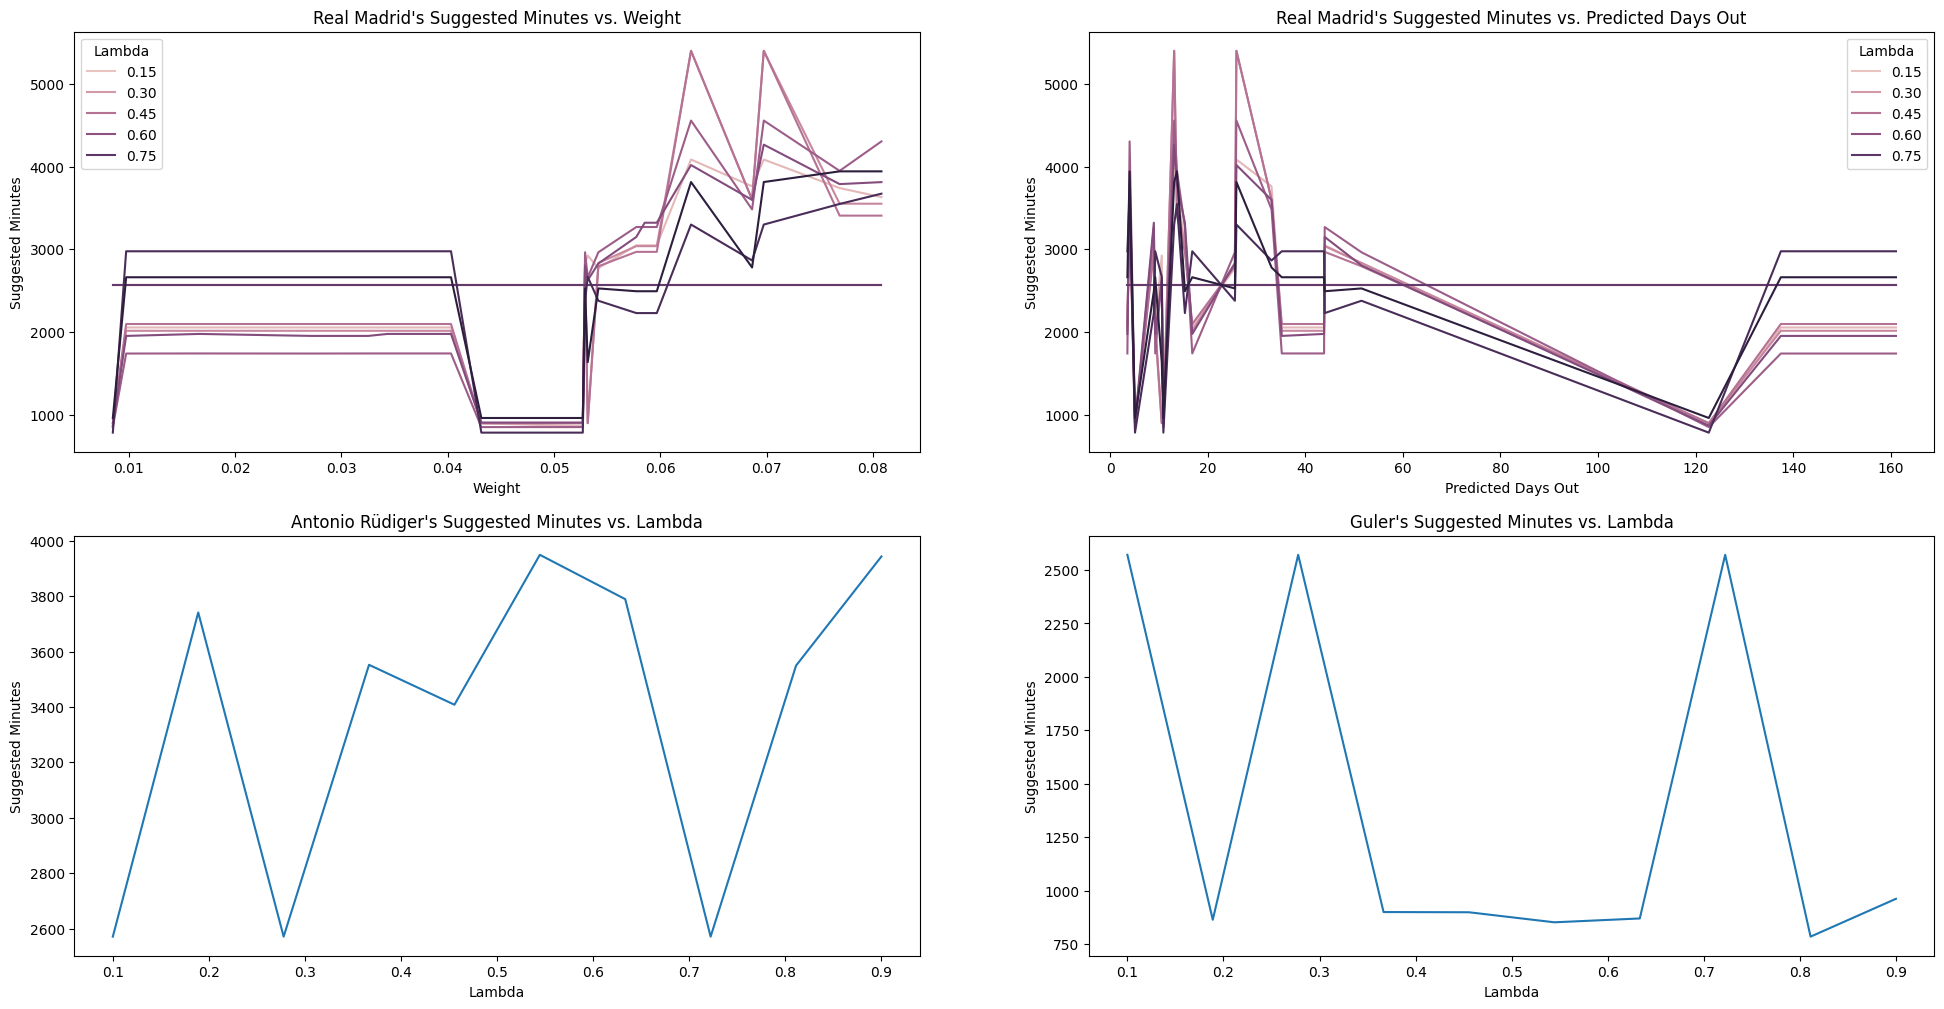

In [62]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise('Real Madrid', total_days_out_mse_prediction_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Real Madrid's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Real Madrid's Suggested Minutes vs. Predicted Days Out")

rudiger_df = results_df[results_df['Name'] == 'Antonio Rüdiger']
sns.lineplot(data=rudiger_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Antonio Rüdiger's Suggested Minutes vs. Lambda")

guler_df = results_df[results_df['Name'] == 'Arda Güler']
sns.lineplot(data=guler_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Guler's Suggested Minutes vs. Lambda")

## Games Per Minute as the variable

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Sergio Gómez's Suggested Minutes vs. Games Per Season")

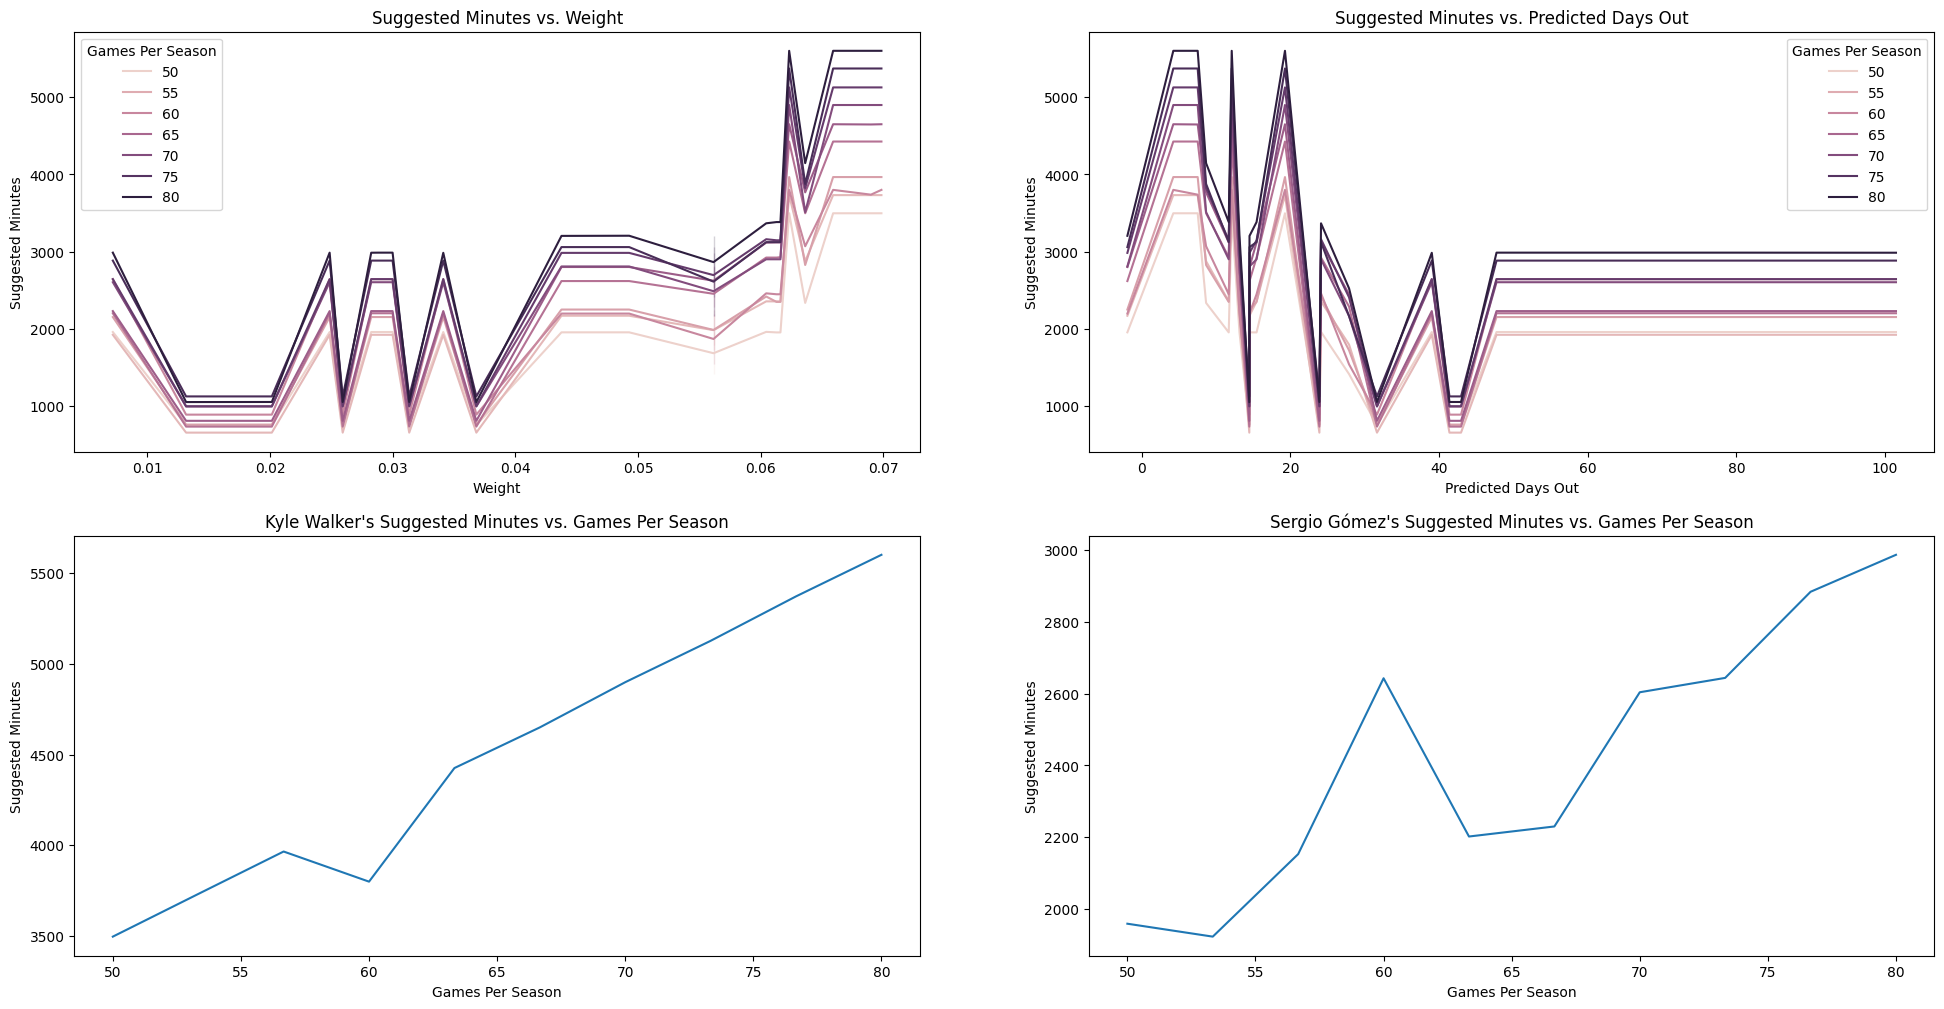

In [66]:
# Create a range of games per season values
games_ps_values = np.linspace(50, 80, num=10)

# Run the optimization for each lambda value
results = []
for games in games_ps_values:
    result = optimise('Man City', total_days_out_mse_prediction_df, games_per_season=games, penalty_lambda=0.9)
    result['Games Per Season'] = np.full(len(result), games)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Games Per Season', ax=axes[0, 0])
axes[0, 0].set_title('Suggested Minutes vs. Weight')

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Days Out', y='Suggested Minutes', hue='Games Per Season', ax=axes[0, 1])
axes[0, 1].set_title('Suggested Minutes vs. Predicted Days Out')

walker_df = results_df[results_df['Name'] == 'Kyle Walker']
sns.lineplot(data=walker_df, x="Games Per Season", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Kyle Walker's Suggested Minutes vs. Games Per Season")

sergio_df = results_df[results_df['Name'] == 'Sergio Gómez']
sns.lineplot(data=sergio_df, x="Games Per Season", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Sergio Gómez's Suggested Minutes vs. Games Per Season")

In [4]:
average_injury_cost_mse_prediction_df = pd.read_csv('/kaggle/input/average-injury-cost-predictions/avg_injury_cost_mse_prediction.csv')
injury_count_mse_prediction_df = pd.read_csv('/kaggle/input/injury-count-predictions/injury_count_mse_prediction.csv')
injury_count_cost_combined_df = injury_count_mse_prediction_df
injury_count_cost_combined_df['Predicted Average Injury Cost'] = average_injury_cost_mse_prediction_df['Predicted Average Injury Cost']

In [5]:
injury_count_cost_combined_df.head()

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Injury Count,Predicted Average Injury Cost
0,Tosin Adarabioyo,Fulham,26,1995,0.041889,1.894689,0.295183
1,Issa Diop,Fulham,27,1949,0.040923,2.068261,0.317022
2,Calvin Bassey,Fulham,24,2562,0.053794,1.066523,0.168393
3,Tim Ream,Fulham,36,1692,0.035527,1.387498,0.210753
4,Antonee Robinson,Fulham,26,3749,0.078718,0.895854,0.145121


## When Objective function is based on 'Injury Count' and 'Average Injury Cost'
Given a squad of $n$ players which plays $g$ number of games per season, the objective function is

$\begin{align*} 
    \min \; &\lambda \sum_{i = 1}^{n} w_i y_i c_i x_i + (1 - \lambda)\delta(x_i - \text{ min. playing time})^2\\
    \text{s.t. } &\sum_{i = 1}^{n} x_i = 90 \times 10 \times g\\
    &90 \times l_k \times g \leq x_i \leq 90 \times u_k \times g\\
    & x_i \geq 0
\end{align*}$

where $w_i$ is the **weight (importance)**, $y_i$ is the **predicted injury count**, $c_i$ is the **predicted average injury cost** and $x_i$ is the **minutes played across the whole season** for player $i$. $\lambda$ is the tradeoff term between minimizing injury risk and ensuring performance, while $\delta$ controls the severity of the penalty. 

$l_k$ and $u_k$ are the lower and upper bound of the age group playing time that player $i$ belongs to which by default follows this table:

|    Age Group | Suggested Minutes Lower Bound | Suggested Minutes Upper Bound |
|-------------:|------------------------------:|------------------------------:|
|     16 to 22 |                            15 |                            60 |
|     23 to 35 |                            70 |                            90 |
| 35 and above |                            15 |                            70 |

In other words, given a team of players, we are trying to minimise potential impact of player $i$'s injuries on the team. At the same time, we want to ensure that important players still play a fair amount of games even if their predicted days out due to injury is high. A higher $w_i y_i c_i x_i$ value indicates a greater negative impact due to:

- Higher weight: The player is more important to the team.
- Higher predicted injury count: The player is more likely to be injured multiple times across the season.
- Higher predicted average injury cost: The player's injuries are more likely to be costlier.
- Higher playing time: The player is exposed to more potential injury risks.

By minimizing this objective, the optimization problem seeks to allocate playing time in a way that reduces the overall negative **economic** impact of injuries on the team but still taking into consideration the performance of the team. This can help ensure that the team remains competitive and avoids incurring excessive injury costs.

Note that the variables $g, \; \lambda, \; \delta$ and the age group constraints are adjustable based on the needs of different teams.

In [11]:
def cost_objective_function(x, df, games_per_season, age_ranges, lambda_penalty=0.5):
    """
    Calculates the weighted sum of predicted total days out.

    Args:
    x: Array of playing minutes for each player.
    df: DataFrame containing player data (e.g., weights, predicted days out, age).
    games_per_season: Number of games played per season.
    minutes_per_age: Dictionary of minutes limits for different age groups.
    lambda_penalty: Tradeoff control between minimizing injury risk and ensuring playing time.

    Returns:
    The weighted sum of predicted total days out.
    """

    predicted_injury_count = df['Predicted Injury Count'].values
    predicted_injury_cost = df['Predicted Average Injury Cost'].values
    weights = df['Weight'].values
    min_playing_time = df['Min Playing Time'].values
    
    # Calculate penalty term
    penalty = 1000 * np.power(x - min_playing_time, 2)
    return lambda_penalty * np.dot(weights, predicted_injury_count * predicted_injury_cost * x) + (1 - lambda_penalty) * (np.sum(penalty))

In [12]:
def optimise_cost(club_name, df, age_ranges=default_age_ranges, games_per_season=50, penalty_lambda=0.5):
    club_players_df = df[df['Club'] == club_name]
    num_players = len(club_players_df)
    total_available_minutes = games_per_season * 90 * 10
    base_min_playing_time = total_available_minutes / num_players
    club_players_df = get_min_playing_times(base_min_playing_time, club_players_df)

    x0 = np.full(num_players, base_min_playing_time)  # Initial guess for playing minutes

    constraints = ({'type': 'eq', 'fun': lambda x: total_playing_time_constraint(x, games_per_season)},
                 {'type': 'ineq', 'fun': lambda x: age_ub_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': lambda x: age_lb_constraint(x, club_players_df, games_per_season, age_ranges)},
                 {'type': 'ineq', 'fun': non_negative_constraint})

    # Solve the optimization problem
    result = minimize(cost_objective_function, x0, args=(club_players_df, games_per_season, age_ranges, penalty_lambda), method='SLSQP', constraints=constraints)

    optimal_playing_minutes = result.x
    rounded_optimal_playing_minutes = [round(value) for value in optimal_playing_minutes]
    club_players_df['Lambda'] = penalty_lambda  # Store the used lambda value for each player
    club_players_df['Suggested Minutes'] = rounded_optimal_playing_minutes
    return club_players_df

## Lambda as the variable

In [14]:
man_city_cost_df = optimise_cost('Man City', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.9)

In [15]:
man_city_cost_df

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Injury Count,Predicted Average Injury Cost,Min Playing Time,Lambda,Suggested Minutes
198,Rúben Dias,Man City,27,3817,0.061609,0.418027,0.077455,2934.782609,0.9,2383
199,Manuel Akanji,Man City,28,3861,0.062319,0.599638,0.114154,3521.739130,0.9,3795
200,Nathan Aké,Man City,29,3053,0.049278,0.837909,0.139480,2347.826087,0.9,2189
201,John Stones,Man City,30,1858,0.029990,1.071749,0.187607,0.000000,0.9,2661
202,Taylor Harwood-Bellis,Man City,22,3942,0.063627,0.359863,0.077122,3521.739130,0.9,2995
203,Josko Gvardiol,Man City,22,3479,0.056154,0.790046,0.125385,2347.826087,0.9,1733
204,Sergio Gómez,Man City,23,445,0.007183,1.006816,0.182618,0.000000,0.9,2661
205,Josh Wilson-Esbrand,Man City,21,1248,0.020144,0.921236,0.160586,0.000000,0.9,896
206,Rico Lewis,Man City,19,1606,0.025922,0.407508,0.073580,0.000000,0.9,896
207,Kyle Walker,Man City,34,4083,0.065903,0.820027,0.154623,3521.739130,0.9,3795


Text(0.5, 1.0, 'Suggested Minutes vs. Predicted Average Injury Cost')

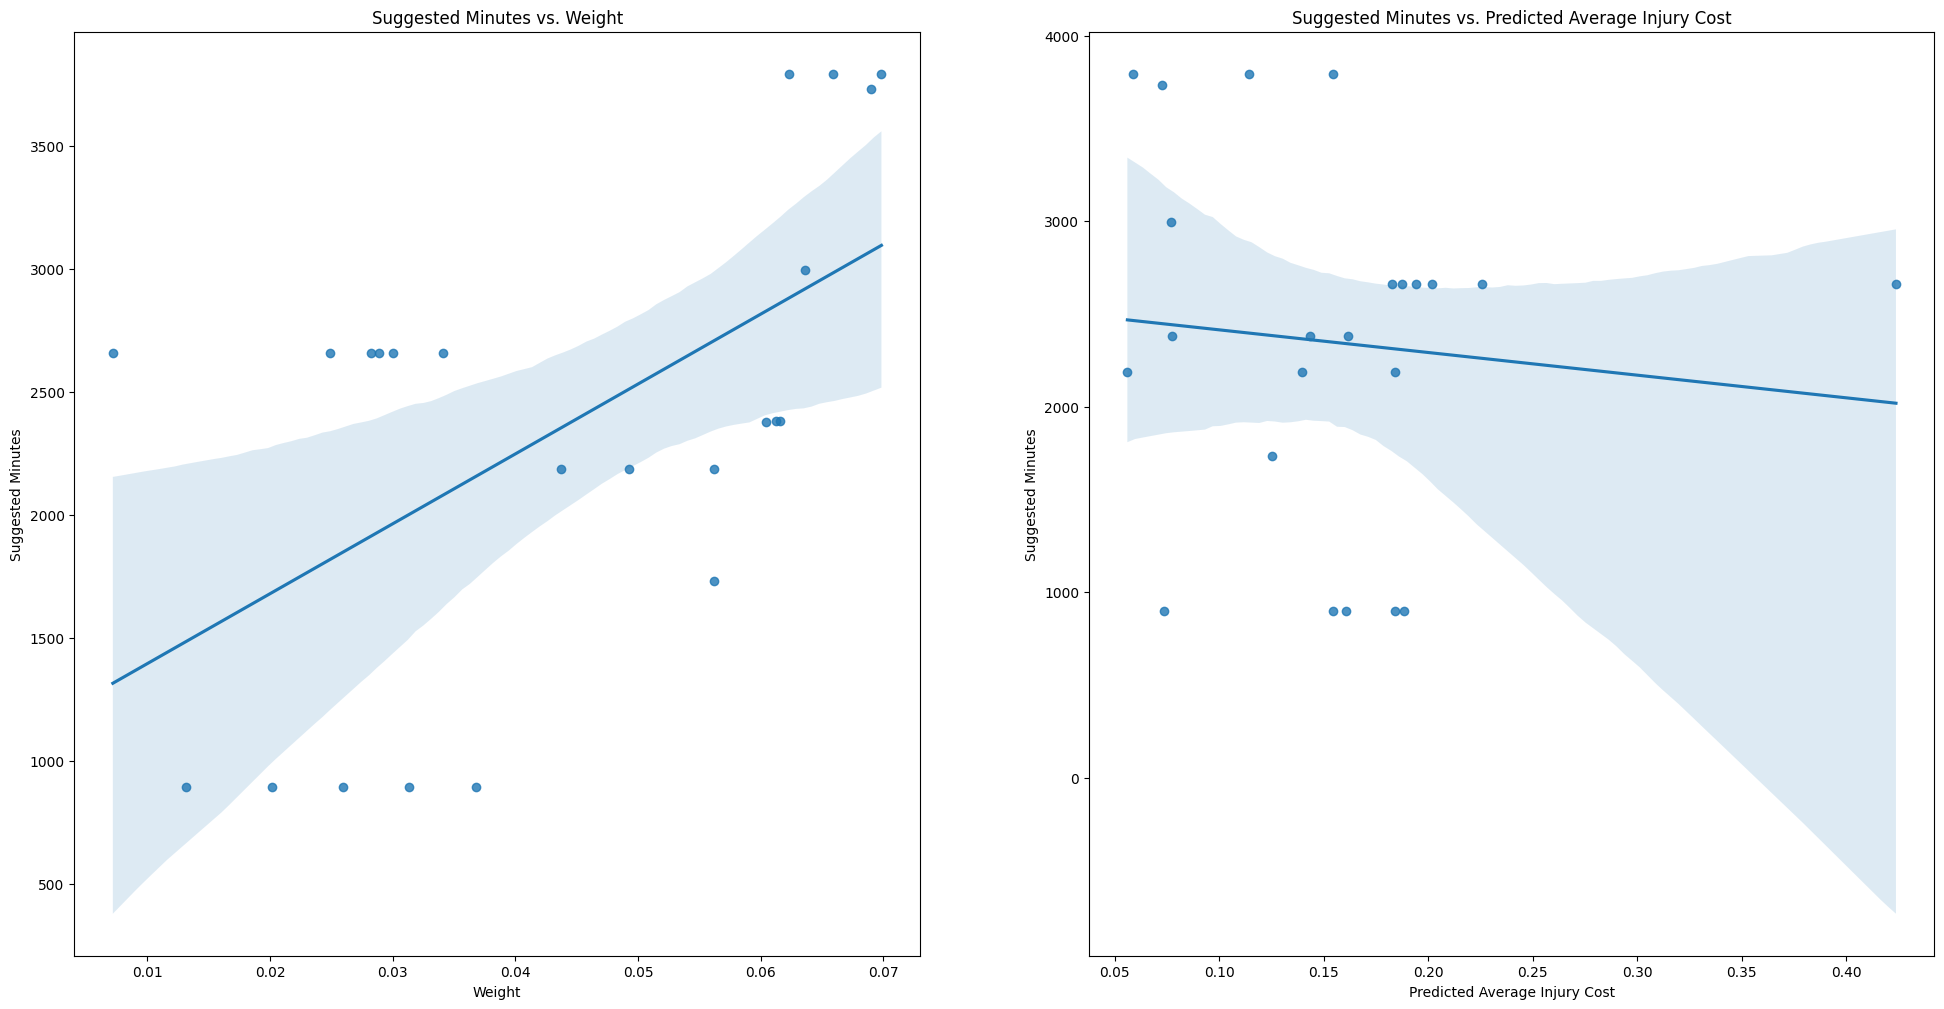

In [29]:
# Create separate line charts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
# Plot suggested minutes vs. weights
sns.regplot(data=man_city_cost_df, x='Weight', y='Suggested Minutes', ax=axes[0])
axes[0].set_title('Suggested Minutes vs. Weight')

sns.regplot(data=man_city_cost_df, x='Predicted Average Injury Cost', y='Suggested Minutes', ax=axes[1])
axes[1].set_title('Suggested Minutes vs. Predicted Average Injury Cost')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Sergio Gómez's Suggested Minutes vs. Lambda")

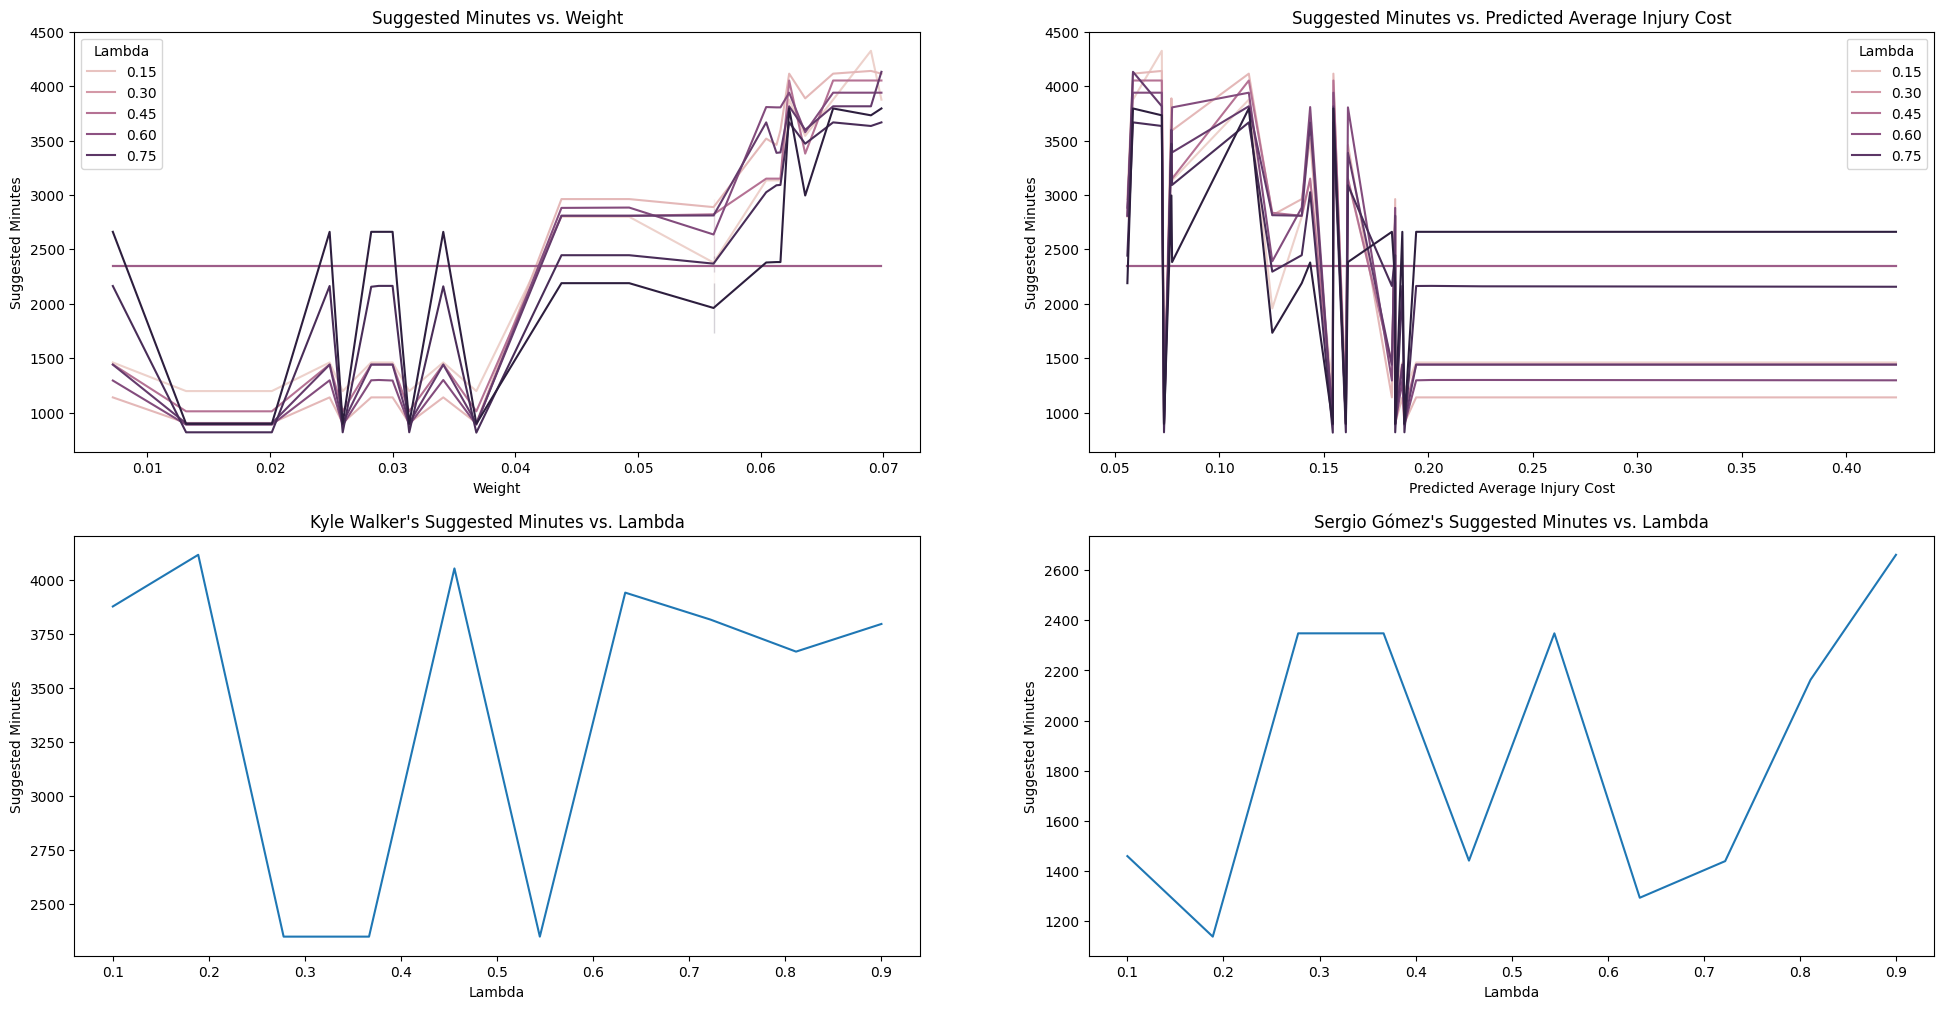

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise_cost('Man City', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Manchester City's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Average Injury Cost', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Manchester City's Suggested Minutes vs. Predicted Average Injury Cost")

walker_df = results_df[results_df['Name'] == 'Kyle Walker']
sns.lineplot(data=walker_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Kyle Walker's Suggested Minutes vs. Lambda")

sergio_df = results_df[results_df['Name'] == 'Sergio Gómez']
sns.lineplot(data=sergio_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Sergio Gómez's Suggested Minutes vs. Lambda")

In [21]:
real_madrid_cost_df = optimise_cost('Real Madrid', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=0.9)
real_madrid_cost_df

,Name,Club,Age,Minutes Played Total 23/24:,Weight,Predicted Injury Count,Predicted Average Injury Cost,Min Playing Time,Lambda,Suggested Minutes
849,Éder Militão,Real Madrid,26,505,0.009740,1.664194,0.191881,0.000000,0.9,2628
850,David Alaba,Real Madrid,31,1407,0.027136,1.827713,0.191089,0.000000,0.9,2628
851,Antonio Rüdiger,Real Madrid,31,3986,0.076876,0.849199,0.101068,3857.142857,0.9,3957
852,Nacho Fernández,Real Madrid,34,3035,0.058534,0.821950,0.094891,3214.285714,0.9,2524
853,Ferland Mendy,Real Madrid,28,2744,0.052922,1.172565,0.140087,2571.428571,0.9,2545
854,Fran García,Real Madrid,24,1686,0.032517,0.676970,0.070525,0.000000,0.9,2628
855,Daniel Carvajal,Real Madrid,32,3261,0.062893,0.910487,0.090548,3857.142857,0.9,3831
856,Lucas Vázquez,Real Madrid,32,1780,0.034330,0.735942,0.086162,0.000000,0.9,2628
857,Aurélien Tchouaméni,Real Madrid,24,2809,0.054176,0.903665,0.111923,2571.428571,0.9,2545
858,Federico Valverde,Real Madrid,25,4190,0.080810,0.283769,0.046067,3857.142857,0.9,3957


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

Text(0.5, 1.0, "Guler's Suggested Minutes vs. Lambda")

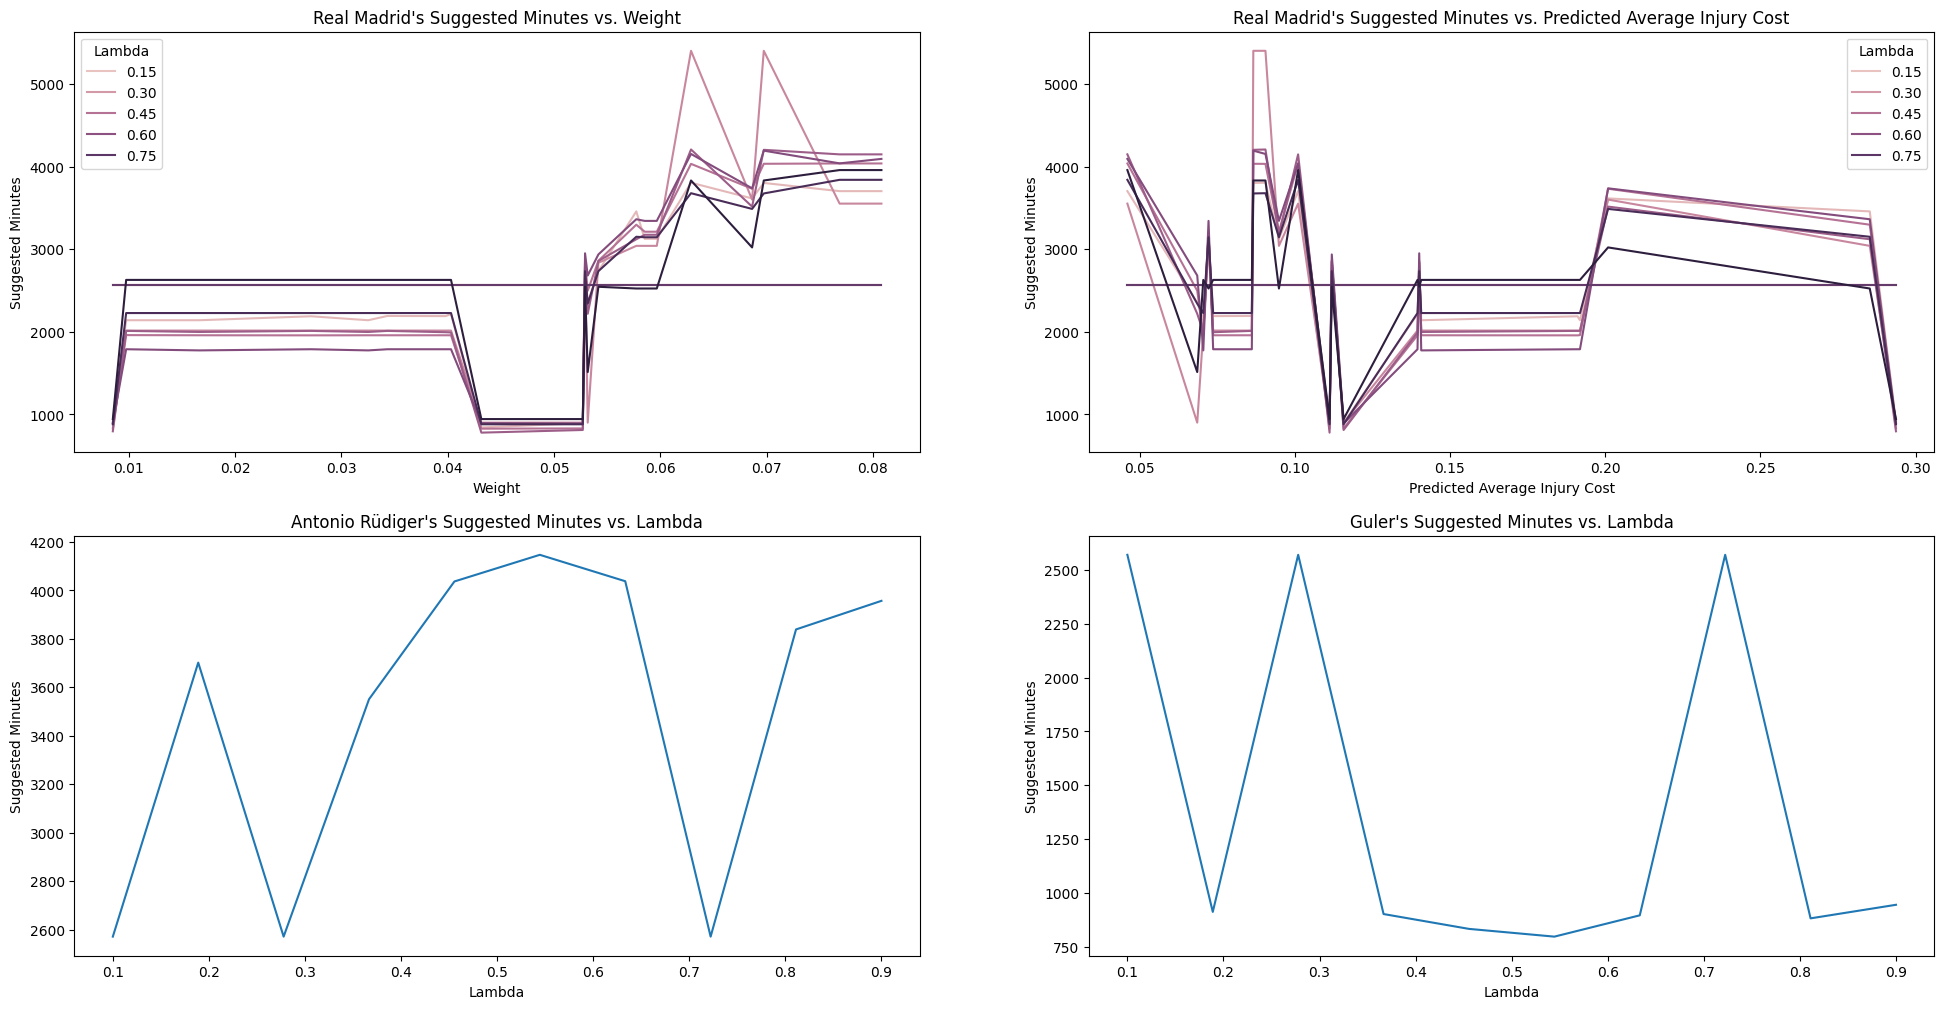

In [22]:
# Create a range of lambda values
lambda_values = np.linspace(0.1, 0.9, num=10)

# Run the optimization for each lambda value
results = []
for lambda_value in lambda_values:
    result = optimise_cost('Real Madrid', injury_count_cost_combined_df, games_per_season=60, penalty_lambda=lambda_value)
    results.append(result)

# Combine results into a DataFrame
results_df = pd.concat(results, ignore_index=True)

# Create separate line charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

# Plot suggested minutes vs. weights
sns.lineplot(data=results_df, x='Weight', y='Suggested Minutes', hue='Lambda', ax=axes[0, 0])
axes[0, 0].set_title("Real Madrid's Suggested Minutes vs. Weight")

# Plot suggested minutes vs. predicted days out
sns.lineplot(data=results_df, x='Predicted Average Injury Cost', y='Suggested Minutes', hue='Lambda', ax=axes[0, 1])
axes[0, 1].set_title("Real Madrid's Suggested Minutes vs. Predicted Average Injury Cost")

rudiger_df = results_df[results_df['Name'] == 'Antonio Rüdiger']
sns.lineplot(data=rudiger_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 0])
axes[1, 0].set_title("Antonio Rüdiger's Suggested Minutes vs. Lambda")

guler_df = results_df[results_df['Name'] == 'Arda Güler']
sns.lineplot(data=guler_df, x="Lambda", y="Suggested Minutes", ax=axes[1, 1])
axes[1, 1].set_title("Guler's Suggested Minutes vs. Lambda")